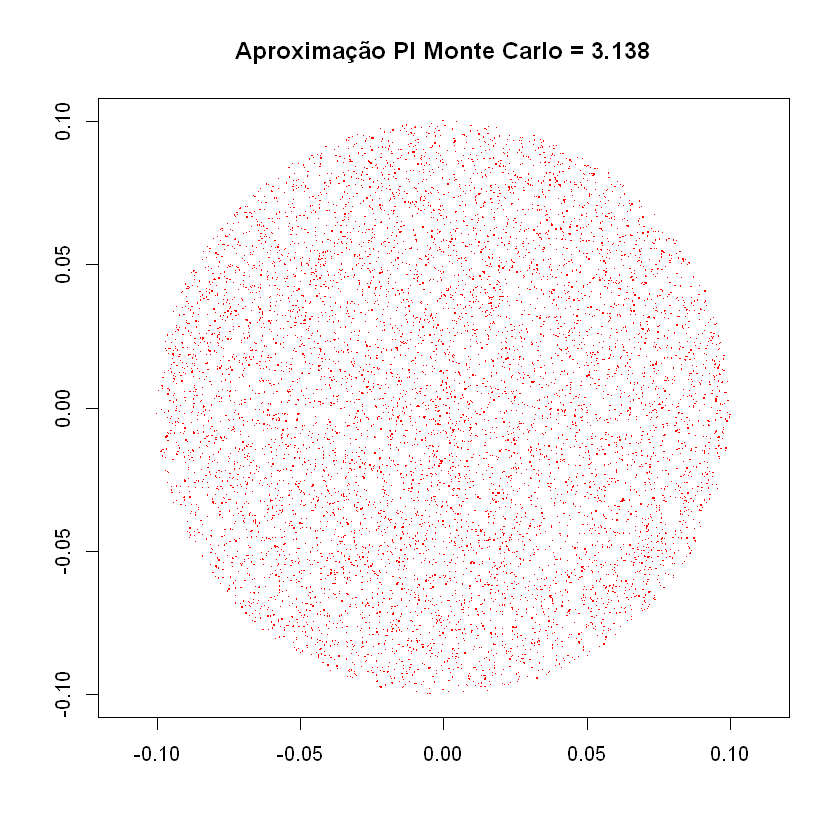

In [74]:
n_sim <- 10000
minimo <- -0.1
if(minimo >= 0){
    break
}
maximo <- -minimo
x <- runif(n_sim, minimo, maximo)
y <- runif(n_sim, minimo, maximo)

dentro_circulo <- x^2 + y^2 <= maximo^2

pi_monte_carlo <- (sum(dentro_circulo)/n_sim)*4

plot(x,y,pch='.',col=ifelse(dentro_circulo,"red","white")
    ,xlab='', ylab='',asp=1,
    main=paste("Aproximação PI Monte Carlo =", pi_monte_carlo))

In [111]:
library(stats)
library(ggplot2)
periodo <- 1:252

In [112]:
u <- 0.255674

sd <- 0.1306887

In [113]:
n_sim <- 2000
total_sim <- matrix(0, nrow = length(periodo), ncol = n_sim)
p_inicial <- 100

In [114]:
for(j in 1:n_sim){
    aux <- 2
    p <- p_inicial
    preco <- c(p)
    dist <- rnorm((length(periodo)-1), 0, 1)
    for(i in dist)
    {
        P = p + p*(u/(length(periodo)-1) + sd/sqrt(length(periodo)-1)*i)
        preco[aux] <- P
        p = P
        aux = aux + 1
    }
    total_sim[,j] <- preco
}

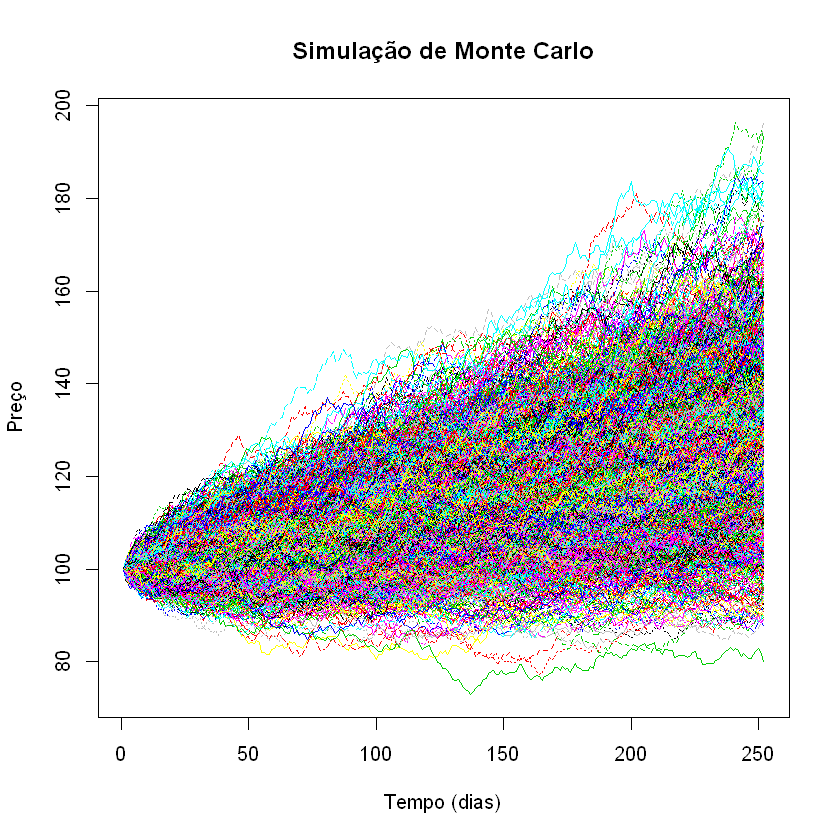

In [115]:
matplot(total_sim,
        main="Simulação de Monte Carlo",
        xlab="Tempo (dias)",ylab="Preço",
        col=1:n_sim, type = "l")

In [116]:
round(quantile(total_sim,probs=c(0.05,0.95)),2)

5%    95% 
 96.83 139.82

In [117]:
p_5 <- qnorm(0.05)
p_1 <- qnorm(0.01)

In [118]:
Ug <- (1+u)^(1/(length(periodo)-1))-1
sd_d <- sd/sqrt((length(periodo)-1))
VaR5 <- round((1-exp(p_5*sd_d+Ug))*100,3)
names(VaR5) <- "VaR diário em % com 5% chance"
VaR5
VaR1 <- round((1-exp(p_1*sd_d+Ug))*100,3)
names(VaR1) <- "VaR diário em % com 1% de chance"
VaR1

VaR diário em % com 5% chance 
                        1.258

VaR diário em % com 1% de chance 
                           1.812

In [119]:
Ug_m <- (1+u)^(1/21)-1
sd_m <- sd/sqrt(21)
VaR5_m <- round((1-exp(p_5*sd_m+Ug_m))*100,3)
names(VaR5_m) <- "VaR mensal em % com 5% chance"
VaR5_m
VaR1_m <- round((1-exp(p_1*sd_m+Ug_m))*100,3)
names(VaR1_m) <- "VaR mensal em % com 1% de chance"
VaR1_m

VaR mensal em % com 5% chance 
                        3.537

VaR mensal em % com 1% de chance 
                           5.393

In [120]:
round(min(total_sim),2)

[1] 72.93

In [121]:
estatisticas <- round(c(mean(total_sim[length(periodo),]), min(total_sim),
                  max(total_sim), 100*(quantile(total_sim[length(periodo),], probs = 0.5)/p_inicial)-100),2)
names(estatisticas) <- c("Média final", "Mínimo", "Máximo", "Retorno 50% em %")
print(estatisticas)

     Média final           Mínimo           Máximo Retorno 50% em % 
          128.59            72.93           196.66            27.77 


In [122]:
fora_curva <- round(c(((min(total_sim)/p_inicial)-1)*100,
                      ((max(total_sim)/p_inicial)-1)*100),3)
names(fora_curva) <- c("Perda Máxima %", "Ganho Máximo %")
print(fora_curva)

Perda Máxima % Ganho Máximo % 
       -27.071         96.656 


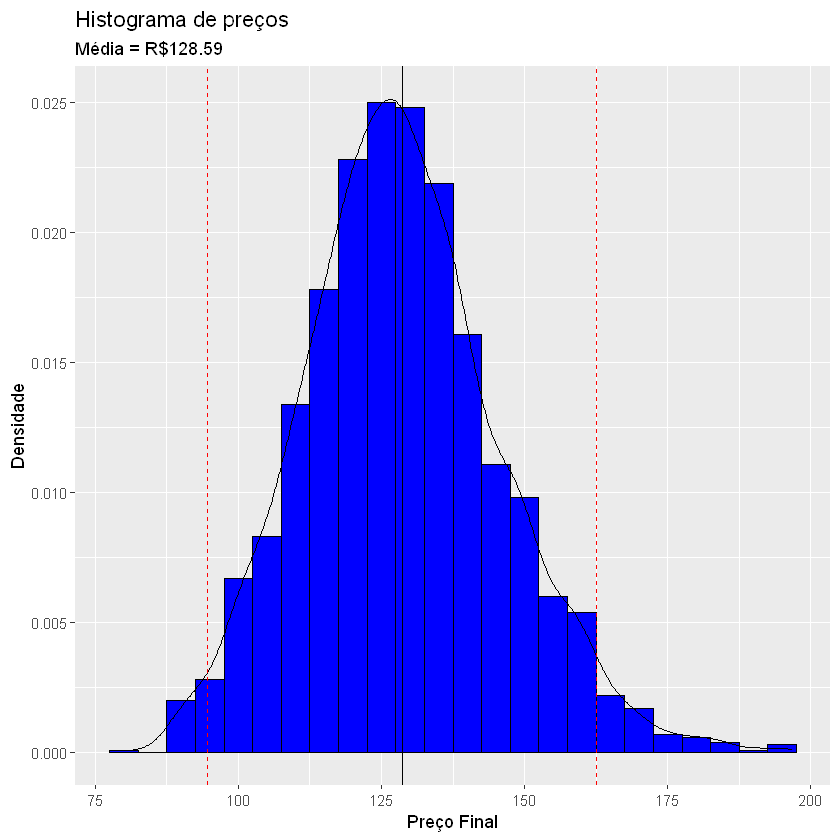

In [123]:
data <- data.frame(Final = total_sim[nrow(total_sim),])
ggplot(data, aes(x = Final, after_stat(density)))+
  geom_histogram(fill = "blue", col = "black", binwidth = 5)+
  geom_density()+
  geom_vline(xintercept = c(mean(data$Final),
                            mean(data$Final)+2*sd(data$Final),
                            mean(data$Final)-2*sd(data$Final)),
             col = c("black", "red", "red"), lty = c(1,2,2))+
  labs(x = "Preço Final", y = "Densidade", title = "Histograma de preços",
       subtitle = paste0("Média = R$",round(mean(data$Final),2)))

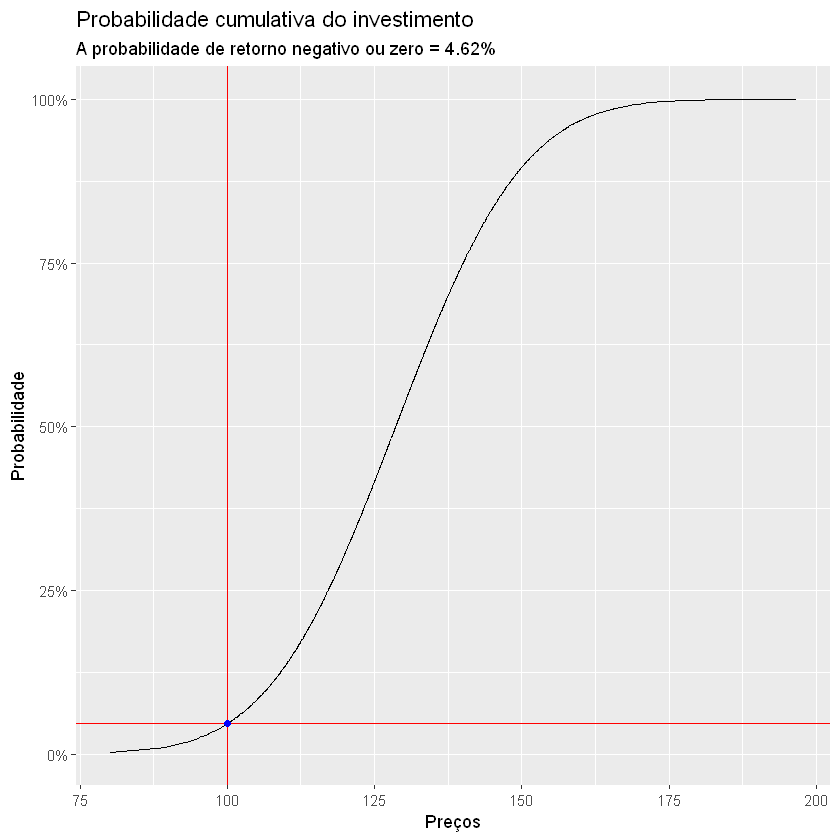

In [126]:
prob1 <- pnorm(data$Final, mean = mean(data$Final), sd = sd(data$Final))
prob1 <- data.frame(Preços = sort(data$Final), Probabilidade = sort(prob1))
pre <- pnorm(100, mean = mean(prob1$Preços), sd = sd(prob1$Preços))
ggplot(prob1, aes(x = Preços, y = Probabilidade))+
  geom_line()+
  geom_hline(yintercept = pre, col = "red")+
  geom_vline(xintercept = 100, col = "red")+
  labs(title = "Probabilidade cumulativa do investimento",
       subtitle = paste0("A probabilidade de retorno negativo ou zero = ",round(pre*100,2),"%"))+
  geom_point(aes(x = 100, y = pre), col = "blue")+
  scale_y_continuous(labels = scales::percent)

In [125]:
#Critério de Kelly
a <- 1-pre
g <- (max(data$Final)+p_inicial)/(2*p_inicial)-1
kelly <- a-((1-a)/g)
names(kelly) <- "% do capital a ser alocado"
print(kelly*100)

% do capital a ser alocado 
                  85.80895 
